# Get structures and categorize

### 1. Get structure

In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from  pymatgen.core.structure import Structure as ST
from pymatgen.core.sites import Site
from pymatgen.analysis.nmr import ChemicalShielding
from pymatgen.io import ase
from pymatgen.analysis.local_env import CrystalNN
from pymatgen.analysis.local_env import NearNeighbors
from pymatgen.analysis.nmr import ElectricFieldGradient
import copy
import itertools
import statistics
from ase import io
from pymatgen.io import ase
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
with open('Alnmr.json','r') as file:
    data=json.load(file)
    print("length of file is {}".format(len(data)))

length of file is 3479


In [3]:
def get_structure_NMR (data):
    """
    CONVERT THE TYPE OF STRUCTURE INFO FROM "DICT" TO "STRUCTURE"
    CALCULATE NMR PARAMS OF THE ATOM OF INTEREST FROM RAW TENSOR 
    """
    compounds=[]
#     c_index=0
    for compound in tqdm(data,position=0):
        if compound == {}:
            continue
        tensors=[]
        site_index=0
        structure=ST.from_dict(compound['structure'])
#         structure.add_oxidation_state_by_guess() ##Very time comsuing, comment out for now
        for site in structure.sites:
            lengthes=[]
            if site.species_string[:2]=='Al':
                #add nmr tensor informations
                cs_origin=compound['cs'][site_index]
                cs_symmetric=0.5*(cs_origin+np.transpose(cs_origin))
                cs=ChemicalShielding(cs_symmetric)
                efg_origin=compound['efg'][site_index]
                efg=ElectricFieldGradient(efg_origin)
                tensor={'diso':cs.haeberlen_values[0],
                        'csa':cs.haeberlen_values[1],
                        'csa_reduced':cs.haeberlen_values[2],
                        'etacs':cs.haeberlen_values[3],
                        'etaQ':efg.asymmetry,
                        'CQ':efg.coupling_constant(specie='Al'),
                        'site_index':site_index,
                        'site_coord':list(site.coords)}
                tensors.append(tensor)
            site_index+=1
        compounds.append({"structure":structure,'tensors':tensors})
#         print(c_index)
#         c_index+=1
    return(compounds)

In [4]:
def get_composition(structure):
    atom_list = []
    for site in structure.sites:
        atom_list.append(site.species_string)
    return (list(set(atom_list)))

In [5]:
structures_tensors=get_structure_NMR(data)
print(len(structures_tensors))

 35%|███▍      | 1209/3479 [00:09<00:19, 119.03it/s]/home/he/anaconda3/lib/python3.7/site-packages/pymatgen/analysis/nmr.py:180: RuntimeWarning: invalid value encountered in double_scalars
  return np.abs((V[1] - V[0]) / V[2])
100%|██████████| 3479/3479 [00:26<00:00, 129.49it/s]

3471


### 2. Categorization
1. Based on distribution of diso (outliers)
2. Based on atom species
3. Based on coordication numbers
4. Based on Qn values

1. Outliers on diso

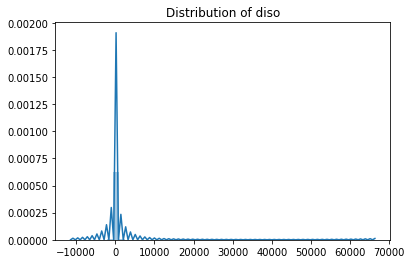

upper outer fence: 747.2221646666668 lower outer fence -162.3005514166669
437
3034


In [6]:
def getDisoList(structures_tensors):
    diso_list = []
    for structure_tensor in structures_tensors:
        for tensor in structure_tensor['tensors']:
            diso_list.append(tensor['diso'])
    return(diso_list)

#view the distribution of diso
diso_list = getDisoList(structures_tensors)

plt.figure()
plt.title('Distribution of diso')
sns.distplot(diso_list)
plt.show()

#determine the upper fence and lowers fence based on theory of box plot
median = np.median(diso_list)
upper_quartile = np.percentile(diso_list, 75)
lower_quartile = np.percentile(diso_list, 25)

iqr = upper_quartile - lower_quartile
upper_outer_fence=upper_quartile+3*iqr
lower_outer_fence=lower_quartile-3*iqr

print('upper outer fence:',upper_outer_fence,'lower outer fence',lower_outer_fence)

#use the upper and lower fence to group the outliers and inliers
outliers =[]
inliers = []
for structure_tensor in structures_tensors:
    lenth = len(structure_tensor['tensors'])
    count=0
    for tensor in structure_tensor['tensors']:
        if tensor['diso']<upper_outer_fence and tensor['diso']>lower_outer_fence:
            count+=1
    if count==lenth:
        inliers.append(structure_tensor)
    else:
        outliers.append(structure_tensor)
print(len(outliers))
print(len(inliers))

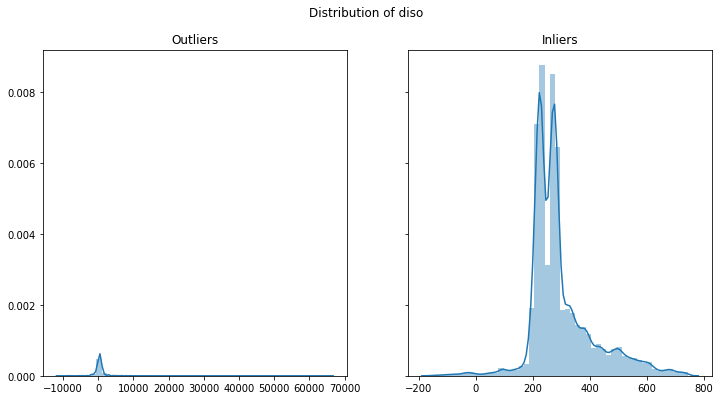

In [7]:
# view the distribution of diso for inliers and outliers
diso_out_list=getDisoList(outliers)
diso_in_list=getDisoList(inliers)

fig, axes = plt.subplots(1,2,figsize=[12,6],sharey=True)
sns.distplot(diso_out_list,ax=axes[0])
sns.distplot(diso_in_list,ax=axes[1])
fig.suptitle('Distribution of diso')
axes[0].title.set_text('Outliers')
axes[1].title.set_text('Inliers')
plt.show()

2. atom species

In [10]:
# Atom Species
structures_tensors_compositon_sorted={}
occur = []
for structure_tensor in inliers:
    compo = get_composition(structure_tensor['structure'])
    print(compo)
    occur.extend(compo)
    species = list(set(occur))
    structures_tensors_compositon_sorted.setdefault(str(compo),[]).append(structure_tensor)

['O', 'Na', 'H', 'F', 'Si', 'Al', 'B', 'Fe']
['O', 'Si', 'Al', 'Ba', 'N']
['O', 'Na', 'Si', 'Al', 'Be']
['O', 'Na', 'Si', 'Al', 'Be', 'Cl']
['O', 'Si', 'Al', 'Li', 'N']
['O', 'Si', 'Al', 'Ba', 'Yb', 'N']
['O', 'Si', 'Al', 'Sr', 'N']
['O', 'Si', 'Al', 'Ba', 'N']
['O', 'Si', 'Al', 'H', 'Ca']
['O', 'Si', 'Al', 'H', 'Ca']
['O', 'Si', 'Al', 'H', 'Ca']
['O', 'Si', 'Al', 'Be', 'H']
['O', 'Si', 'Al', 'Nd', 'N']
['O', 'Si', 'Al', 'Fe', 'Mg']
['O', 'Na', 'Si', 'Al', 'I']
['O', 'Si', 'Al', 'K', 'Cl']
['O', 'Si', 'Al', 'Ni', 'Sb']
['O', 'Si', 'Al', 'Cl', 'Ca']
['O', 'Si', 'Al', 'Ca', 'Mg']
['O', 'F', 'Si', 'Al', 'Cu']
['Ti', 'O', 'F', 'Si', 'Al', 'Ca']
['O', 'F', 'Si', 'Al', 'Ca']
['O', 'Si', 'Al', 'Ho', 'Ba', 'N']
['O', 'Na', 'Si', 'Al', 'H']
['O', 'C', 'Si', 'Al', 'Cl', 'H']
['O', 'Na', 'Si', 'Al', 'Cl']
['O', 'Si', 'Al', 'H', 'Li']
['O', 'Na', 'Si', 'Al', 'Cl', 'Li']
['O', 'Si', 'Al', 'Sm', 'Ba', 'N']
['O', 'Si', 'Al', 'H', 'Li']
['O', 'Si', 'Al', 'Nd', 'N']
['O', 'Si', 'Al', 'Ca', 'Mg']
['O', 

In [27]:
# rank the atoms based on occurance
occur_count = {}
for atom in occur:
    occur_count.setdefault(str(atom),[]).append(atom)

for k,v in occur_count.items():
    occur_count[k]=len(v)
occur_count_sorted = sorted(occur_count.items(), key=lambda x: x[1],reverse=True)
occur_count_sorted

[('Al', 3034),
 ('O', 1681),
 ('Si', 579),
 ('Mg', 383),
 ('H', 315),
 ('Ca', 250),
 ('Na', 246),
 ('Li', 236),
 ('F', 192),
 ('N', 169),
 ('Fe', 163),
 ('P', 157),
 ('Ba', 148),
 ('Sr', 136),
 ('Cu', 126),
 ('K', 122),
 ('Cl', 120),
 ('Ti', 115),
 ('Co', 113),
 ('C', 112),
 ('Ni', 109),
 ('S', 103),
 ('Mn', 100),
 ('B', 98),
 ('Y', 96),
 ('Ge', 79),
 ('V', 77),
 ('W', 67),
 ('Ce', 63),
 ('Cr', 63),
 ('La', 63),
 ('Sc', 54),
 ('Sb', 53),
 ('Cs', 50),
 ('Zn', 49),
 ('Nd', 48),
 ('Mo', 44),
 ('Rb', 43),
 ('Se', 43),
 ('Bi', 43),
 ('Zr', 42),
 ('Sn', 41),
 ('Pt', 39),
 ('Ag', 38),
 ('Tl', 38),
 ('Ru', 36),
 ('Te', 35),
 ('Lu', 33),
 ('Sm', 32),
 ('Pd', 32),
 ('Ta', 31),
 ('Hf', 31),
 ('Nb', 30),
 ('Au', 30),
 ('As', 30),
 ('Yb', 29),
 ('Er', 29),
 ('U', 29),
 ('Pr', 28),
 ('Be', 27),
 ('Tb', 27),
 ('Dy', 27),
 ('Tc', 26),
 ('Ga', 26),
 ('Cd', 25),
 ('Br', 24),
 ('I', 22),
 ('Ir', 22),
 ('Tm', 22),
 ('Pb', 21),
 ('Ho', 19),
 ('Rh', 19),
 ('Gd', 16),
 ('Os', 14),
 ('Eu', 13),
 ('Th', 13),
 

In [52]:
def structuresWithFirstNAtoms(N,rank,structures_tensors):
    """
    A function that collect structures with atoms only within the set of first N most popular atoms.
    
    PARAM:
    N: define the first N most popular atoms to choose from
    rank: atom popularity ranking file (occur_count_sorted)
    structures_tensors: the original structure tensor combination file, use inliers is preferred.
    """
    atom_list = [k[0] for k in rank[:N]]
    print("First {} most popular atoms:".format(N),atom_list)
    structure_tensor_N = []
    for structure_tensor in inliers:
        compo = get_composition(structure_tensor['structure'])
        #print(type(compo))
        if set(compo).issubset(set(atom_list)):
            structure_tensor_N.append(structure_tensor)
    print("Number of structure with only fist N popular atoms:",len(structure_tensor_N))
    return(structure_tensor_N)

In [53]:
composition=[]
for k,v in structures_tensors_compositon_sorted.items():
    composition.append((k,len(v)))
composition=np.array(composition)
composition = pd.DataFrame(composition.reshape((413,6)))
composition.columns = ['composition','number of structures','composition','number of structures','composition','number of structures']
composition

,composition,number of structures,composition,number of structures,composition,number of structures
0,"['O', 'Na', 'H', 'F', 'Si', 'Al', 'B', 'Fe']",2,"['O', 'Si', 'Al', 'Ba', 'N']",6,"['O', 'Na', 'Si', 'Al', 'Be']",2
1,"['O', 'Na', 'Si', 'Al', 'Be', 'Cl']",6,"['O', 'Si', 'Al', 'Li', 'N']",2,"['O', 'Si', 'Al', 'Ba', 'Yb', 'N']",8
2,"['O', 'Si', 'Al', 'Sr', 'N']",4,"['O', 'Si', 'Al', 'H', 'Ca']",27,"['O', 'Si', 'Al', 'Be', 'H']",2
3,"['O', 'Si', 'Al', 'Nd', 'N']",12,"['O', 'Si', 'Al', 'Fe', 'Mg']",4,"['O', 'Na', 'Si', 'Al', 'I']",2
4,"['O', 'Si', 'Al', 'K', 'Cl']",2,"['O', 'Si', 'Al', 'Ni', 'Sb']",2,"['O', 'Si', 'Al', 'Cl', 'Ca']",6
...,...,...,...,...,...,...
408,"['U', 'Al']",2,"['S', 'Al']",6,"['H', 'Al']",2
409,"['Ir', 'Al']",2,"['Ac', 'Al']",1,"['Br', 'Al']",1
410,"['Ta', 'Al']",1,"['Tm', 'Al']",3,"['Al', 'Sn']",1
411,"['Al', 'W']",1,"['Eu', 'Al']",2,"['Pd', 'Al']",3


3. Coordination numbers

In [ ]:
import warnings

In [ ]:
warnings.filterwarnings("once")

In [ ]:
def get_Ncoord (data):
    crystalnn=CrystalNN()
    data_copy=copy.deepcopy(data)
        
    for compound in tqdm(data_copy):
        tensor_Ncoord=[]
        for tensor in compound['tensors']:
            N=crystalnn.get_cn(compound['structure'],int(tensor['site_index']))
            nn_info=crystalnn.get_nn_info(compound['structure'],int(tensor['site_index']))
            tensor['first_shell_atoms']=nn_info
            tensor_Ncoord.append(tensor)
        compound['{}coord_tensor'.format(N)]=tensor_Ncoord
    return(data_copy)

In [ ]:
structure_tensor_Ncoord = get_Ncoord(structures_tensors)

In [ ]:
structure_tensor_sortbycoord = {}
for N in range(15):
    for compound in structure_tensor_Ncoord:
        if '{}coord_tensor'.format(str(N)) in compound.keys():
            if len(compound['tensors'])==len(compound['{}coord_tensor'.format(str(N))]):
                structure_tensor_sortbycoord.setdefault(str(N),[]).append(compound)

In [ ]:
for k,v in structure_tensor_sortbycoord.items():
    print(k,len(v))

4. Qn numbers

In [ ]:
# code here...

### 3. Get descriptor (SOAP, BPSF...)

1. SOAP

In [54]:
import soaplite
from soaplite import genBasis
from dscribe.descriptors import SOAP

def getSOAPforStruct(structure_tensor, species, rCut = 6.5, nMax = 6, Lmax=6):
    
    # Get structure and atom coord
    atoms = ase.AseAtomsAdaptor.get_atoms(structure_tensor['structure'])
    
    # initialize SOAP
    species = species
    rcut = rCut
    nmax = nMax
    lmax = Lmax

    # Setting up the SOAP descriptor
    soap = SOAP(
        species=species,
        periodic=True,
        rcut=rcut,
        nmax=nmax,
        lmax=lmax,
        crossover=True,
        sparse=True
    )
    
    coord = []
    for tensor in structure_tensor['tensors']:
        coord.append(tensor['site_coord'])
    
    x = soap.create(atoms, positions=coord)

    # SOAP solution: x
    #print("soap size: ", np.shape(x))
    return(x)

In [55]:
def TensorSOAPcombo(structure_tensor, nmr_key, species):
    x = getSOAPforStruct(structure_tensor,species)
    y = []
    for tensor in structure_tensor['tensors']:
        y.append(tensor[nmr_key])
    return(x, y)

In [56]:
import math
from scipy.sparse import coo_matrix,csr_matrix
def SOAPkernel(X,Y):
    numerator = (X).dot(Y.T)[0,0]
    denominator = math.sqrt(csr_matrix.dot(X,X.T)[0,0]*csr_matrix.dot(Y,Y.T)[0,0])
    return((numerator/denominator)**2)

2. BPSF

In [ ]:
# get gaussian symmetry fnx (BPSF)
from matminer.featurizers.site import GaussianSymmFunc
def getGaussianSymFnx(structure_tensor):
    gaussiansym = GaussianSymmFunc(etas_g2=[0.000357,0.003214,0.0028569,0.124980,1.428426],
                              etas_g4=[0.000357,0.003214,0.0028569,0.124980,1.428426],
                              zetas_g4=[1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0],
                              gammas_g4=[1.0,-1.0],
                              cutoff=5.5)
    
    # gaussiansym.feature_labels()
    structure = structure_tensor['structure']
    
    Al_site_idx = []
    for tensor in structure_tensor['tensors']:
        Al_site_idx.append(tensor['site_index'])

    gaussian_sym = []
    for idx in Al_site_idx:
        gaussian_sym_single = gaussiansym.featurize(structure,idx)
        gaussian_sym.append(gaussian_sym_single)
    return(gaussian_sym)

In [ ]:
def TensorGaussianCombo(structure_tensor, nmr_key):
    x = getGaussianSymFnx(structure_tensor)
    y = []
    for tensor in structure_tensor['tensors']:
        y.append(tensor[nmr_key])
    return(x, y)

### 4.Machine learning

#### XY split

In [66]:
# getXY when choose sparse matrix in soap
from scipy.sparse import vstack
from random import sample
def getXY(structures_tensors,num,descriptor,species):
    X=None
    y=[]
    for structure_tensor in tqdm(sample(structures_tensors,num)):
        if descriptor=='soap':
            soap, nmr_param = TensorSOAPcombo(structure_tensor,'diso',species = species)
            if X==None:
                X =soap
            else:
                X = vstack([X,soap])
            y.extend(nmr_param)
        elif descriptor=='gaussian_sym':
            gaussian_sym,nmr_param = TensorGaussianCombo(structure_tensor,'diso')
            X.extend(gaussian_sym)
            y.extend(nmr_param)
        else:
            raise ValueError('descriptor should be choosen between "soap" or "gaussian_sym"!')
    
    if descriptor=='soap':
        X = X
    else:
        X = np.array(X)
    y = np.array(y)
    
    return(X,y)

In [81]:
N = 6
species = [k[0] for k in occur_count_sorted[:N]]

structure_input = structuresWithFirstNAtoms(N,occur_count_sorted,inliers)
X,y = getXY(structure_input,len(structure_input),'soap',species)
print(X.shape,y.shape)

First 6 most popular atoms: ['Al', 'O', 'Si', 'Mg', 'H', 'Ca']


  4%|▍         | 10/261 [00:00<00:02, 90.07it/s]

Number of structure with only fist N popular atoms: 261


100%|██████████| 261/261 [00:06<00:00, 42.12it/s]

(1806, 3087) (1806,)


In [ ]:
test = pd.DataFrame(X)
test.isna().any().any()

In [82]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [83]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(1444, 3087) (1444,) (362, 3087) (362,)


#### Ridge regression

In [ ]:
# Show warnings only once

# import warnings
# warnings.filterwarnings(action='once')

# Grid Search for Algorithm Tuning
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
# create and fit a ridge regression model, testing each alpha
alphas = [1e-7,1e-6,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 20, 50, 100]
model = Ridge(normalize=True,copy_X=True)
grid = GridSearchCV(estimator=model, param_grid=dict(alpha=alphas),scoring='r2',cv=5)
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_.alpha)

In [ ]:
# Predict using kernel ridge
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

y_rr = grid.predict(X_test)

print("score:{}".format(grid.score(X_test,y_test)))

predict_result = pd.DataFrame(np.array([y_rr,y_test])).transpose()
predict_result.rename(columns={1:'DFT_predict',0:'RR_predict'},inplace=True)

plt.figure(figsize=[12,8])
plt.title('Ridge regression of diso (ppm) on SiO2 data set')
plot = sns.scatterplot(x="RR_predict", y="DFT_predict", data=predict_result)
plt.show()

#### Kernel ridge regression

In [84]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# create and fit a kernel ridge regression model
model = KernelRidge()
param = {'alpha':uniform(0,1),
#          'gamma':uniform(0,1e10),
         'kernel':['rbf']}

grid = RandomizedSearchCV(estimator=model, 
                          param_distributions=param,
                          n_iter=20,
                          scoring='r2',
                          cv=3,n_jobs=8)
grid.fit(X_train, y_train)
print(grid)
# summarize the results of the grid search
print(grid.best_score_)
print(grid.best_estimator_)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                         kernel='linear', kernel_params=None),
                   iid='warn', n_iter=20, n_jobs=8,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f98fc1fc080>,
                                        'kernel': ['rbf']},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring='r2', verbose=0)
-4.344002221116806
KernelRidge(alpha=0.012154028542107786, coef0=1, degree=3, gamma=None,
            kernel='rbf', kernel_params=None)
CPU times: user 7.8 s, sys: 4.36 s, total: 12.2 s
Wall time: 29.3 s


score:-1.3335347922330438


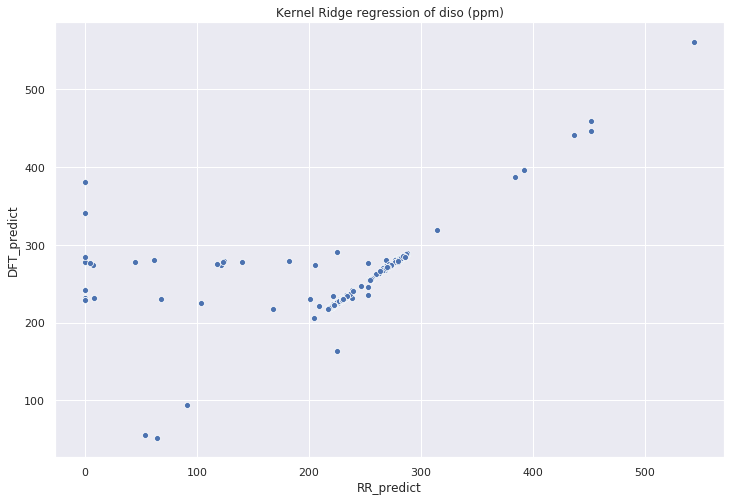

CPU times: user 8.08 s, sys: 266 ms, total: 8.34 s
Wall time: 1.55 s


In [85]:
%%time
# Predict using kernel ridge
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import date


y_rr = grid.predict(X_test)

predict_result = pd.DataFrame([y_rr,np.array(y_test)]).transpose().rename(columns={0:'RR_predict',1:'DFT_predict'})
print("score:{}".format(grid.score(X_test,y_test)))

# write down the date for png save
today = date.today()

plt.figure(figsize=[12,8])
plt.title('Kernel Ridge regression of diso (ppm)')
plot = sns.scatterplot(x="RR_predict", y="DFT_predict", data=predict_result)
plt.savefig('27Al_krr_testSet_{}.png'.format(today))
plt.show()